# Imbalance feature implementation

In [1]:
#libraries importing
import time
import polars as pl
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

In [2]:
#Preprocessing
book = pl.read_csv('book.csv')
book = book.drop(['exchange',	'symbol',	'timestamp',	'local_timestamp'])
book_np = book.to_numpy()
N = (np.median(book_np[:,np.arange(1, 14, 4)], axis = 1)+np.median(book_np[:,np.arange(3, 16, 4)], axis = 1))/2

In [6]:
@njit(nogil=True, fastmath=True, parallel = True)
def run_book(book_np, N):
    IMB_a = np.zeros(len(book_np))
    IMB_b = np.zeros(len(book_np))
    for row in range(len(book_np)):
        p_a = 0
        need_to_buy = N[row]
        for i in range(1, 100, 4):
            if need_to_buy <= book_np[row][i]:
                p_a+=need_to_buy*book_np[row][i-1]
                need_to_buy = 0.
                break
            else:
                p_a+=book_np[row][i]*book_np[row][i-1]
                need_to_buy -=book_np[row][i]
        if need_to_buy !=0.:
            p_a +=need_to_buy*book_np[row][96]
            need_to_buy =0.
        p_a /= N[row]
        IMB_a[row] = (p_a/book_np[row][0] - 1)*10000


        p_b = 0
        need_to_buy = N[row]
        for i in range(3, 100, 4):
            if need_to_buy <= book_np[row][i]:
                p_b+=need_to_buy*book_np[row][i-1]
                need_to_buy = 0.
                break
            else:
                p_b+=book_np[row][i]*book_np[row][i-1]
                need_to_buy -=book_np[row][i]
        if need_to_buy !=0.:
            p_b +=need_to_buy*book_np[row][98]
            need_to_buy =0.
        p_b /= N[row]
        IMB_b[row] = (book_np[row][2]/p_b - 1)*10000
    return IMB_a, IMB_b

IMB_a, IMB_b = run_book(book_np, N)

/home/matvey/.pyenv/versions/3.9.16/envs/ML_project/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


# Check feature

Text(0.5, 1.0, 'Imbalance feature plot')

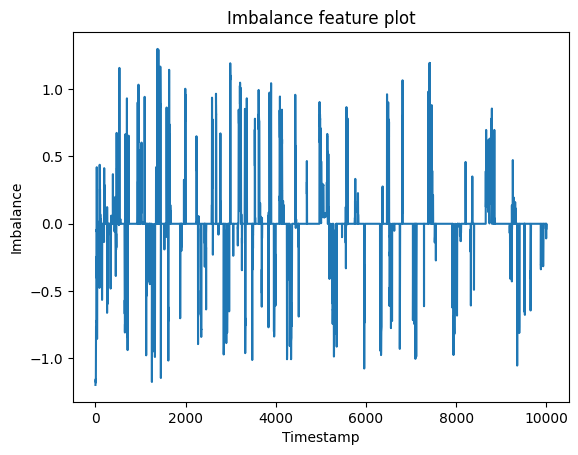

In [26]:

plt.plot(IMB_a[:10000] - IMB_b[:10000])
plt.xlabel('Timestamp')
plt.ylabel('Imbalance')
plt.title('Imbalance feature plot')

# Time comparison

In [7]:
time_numba = %timeit -n 5 -r 5 -o run_book(book_np, N)

118 ms ± 3.45 ms per loop (mean ± std. dev. of 5 runs, 5 loops each)


In [22]:
time_no_numba = %timeit -n 1 -r 1 -o run_book.__wrapped__(book_np, N)

21.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [23]:
time_no_numba.average/time_numba.average

178.92952579258812

In [29]:
import time
times_numba = []
times_no_numba = []
sizes = np.minimum(np.logspace(1, 12, num = 12, dtype = int, base = 4), len(book_np))
for dataset_size in sizes:
    numba = []
    no_numba = []
    for _ in range(3):
        start = time.perf_counter()
        run_book(book_np[:dataset_size], N[:dataset_size])
        numba.append(time.perf_counter() - start)
        start = time.perf_counter()
        run_book.__wrapped__(book_np[:dataset_size], N[:dataset_size])
        no_numba.append(time.perf_counter() - start)
    times_numba.append(np.median(numba))
    times_no_numba.append(np.median(no_numba))

Text(0.5, 1.0, 'Numba vs trivial implementation')

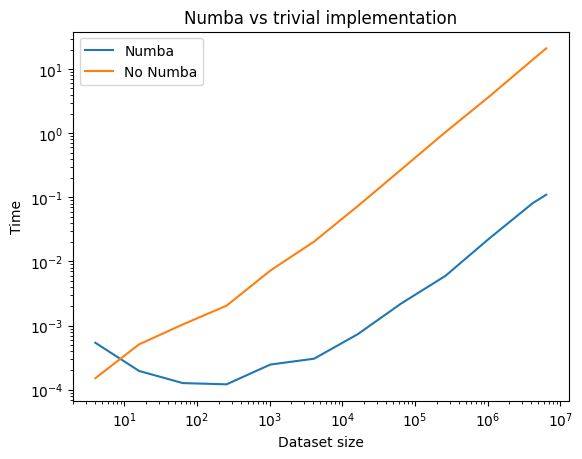

In [30]:
plt.plot(sizes, times_numba, label = 'Numba')
plt.plot(sizes, times_no_numba, label = 'No Numba')
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Dataset size")
plt.ylabel("Time")
plt.legend()
plt.title("Numba vs trivial implementation")